In [1]:
# Instalare librării necesare
!pip install transformers torch datasets tqdm

import torch
from transformers import MarianMTModel, MarianTokenizer, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm import tqdm

c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup dispozitiv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Încărcare model pre-antrenat MarianMT și tokenizer specific pentru limba română
model_name = "Helsinki-NLP/opus-mt-en-ro"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RoG\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-en-ro. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\transformers\models\marian\tokenization_marian.p

In [6]:
# Încărcare dataset "readerbench/ro-text-summarization"
dataset = load_dataset("readerbench/ro-text-summarization")
train_data = dataset["train"]
test_data = dataset["test"]

Generating train split:   0%|          | 0/65268 [00:00<?, ? examples/s]c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\datasets\utils\file_utils.py:1488: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)
Generating test split:   0%|          | 0/7253 [00:00<?, ? examples/s]c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\datasets\utils\file_utils.py:1488: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)
Generating test split: 100%|██████████| 7253/7253 [00:00<00:00, 18937.19 examples/s]


In [7]:
# Funcție pentru pre-procesare text
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z0-9ăîâșțĂÎÂȘȚ ]+", "", text)
    return text

In [8]:
# Funcție pentru pregătirea datelor
import re

def prepare_data(texts, summaries, tokenizer, max_input_length=512, max_target_length=128):
    inputs = tokenizer(texts, max_length=max_input_length, truncation=True, padding=True, return_tensors="pt")
    targets = tokenizer(summaries, max_length=max_target_length, truncation=True, padding=True, return_tensors="pt")
    return inputs.input_ids, inputs.attention_mask, targets.input_ids

# Pre-procesare date
train_inputs, train_masks, train_labels = prepare_data(
    [clean_text(t) for t in train_data["Content"]],
    [clean_text(s) for s in train_data["Summary"]],
    tokenizer
)
test_inputs, test_masks, test_labels = prepare_data(
    [clean_text(t) for t in test_data["Content"]],
    [clean_text(s) for s in test_data["Summary"]],
    tokenizer
)

In [9]:
# Definire dataset Pytorch
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return {
            "input_ids": self.inputs[index],
            "attention_mask": self.masks[index],
            "labels": self.labels[index],
        }

In [10]:
# Creare dataloader
train_dataset = SummarizationDataset(train_inputs, train_masks, train_labels)
test_dataset = SummarizationDataset(test_inputs, test_masks, test_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [11]:
# Setare optimizer și scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

c:\Users\RoG\anaconda3\envs\pythonRL\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Funcție pentru antrenament
def train_epoch(model, dataloader, optimizer, scheduler, epoch):
    model.train()
    losses = []
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")

    for i, batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        progress_bar.set_postfix({"Loss": loss.item()})

    return sum(losses) / len(losses)

In [13]:
# Antrenament
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, epoch + 1)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss}")

Epoch 1: 100%|██████████| 16317/16317 [38:02<00:00,  7.15it/s, Loss=1.15] 


Epoch 1/3 - Loss: 1.9830694291118518


Epoch 2: 100%|██████████| 16317/16317 [38:03<00:00,  7.15it/s, Loss=1.88] 


Epoch 2/3 - Loss: 1.5888549997875663


Epoch 3: 100%|██████████| 16317/16317 [38:03<00:00,  7.15it/s, Loss=1.7]  

Epoch 3/3 - Loss: 1.4920587502595746


In [14]:
model_path = "./marian"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59542]], 'forced_eos_token_id': 0}


('./marian\\tokenizer_config.json',
 './marian\\special_tokens_map.json',
 './marian\\vocab.json',
 './marian\\source.spm',
 './marian\\target.spm',
 './marian\\added_tokens.json')

In [15]:
# Funcție pentru generarea rezumatului
def generate_summary(text):
    inputs = tokenizer(text, max_length=512, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [16]:
# Exemplu de previziuni
for i in range(5):
    text = test_data["Content"][i]
    summary = test_data["Summary"][i]
    pred_summary = generate_summary(text)

    print(f"Original Text: {text}")
    print(f"Original Summary: {summary}")
    print(f"Predicted Summary: {pred_summary}")
    print()

Original Text: Valul doi se plimbă val-vârtej prin Europa și forțează tot mai multe țări să intre în carantină. Ne va face probleme până la Pviaște, spune un renumit virolog german! Germania a intrat de astăzi într-un nou regim de carantină parțială, cu restricții privind ieșirile și cu închiderea restaurantelor, barurilor și cinematografelor la interior. Germanii rămân cu reuniunile în aer liber, dar limitate la maximum 10 persoane – neapărat membrii a cel mult de două familii. E măsura intrată în vigoare într-o zi cu 12 mii de infectări și 49 de decese. Puțin mai la est, Slovacia a bătut în weekend recordul de testări într-o zi! A testat jumătate din populație – adică două milioane și jumătate de oameni. Slovacii au descoperit 25 de mii de infectări – adică 1% procent de pozitivitate! La lockdown revin și portughezii – 70% din populație va fi carantinată la domiciliu din 4 noiembrie, în timp ce Grecia a decis odată cu ajungerea la 1.500 de infectări pe zi să închidă barurile și resta

In [32]:
print(test_data[:5])

{'Category': ['sanatate', 'guvern', 'stiinta', 'justitie', 'guvern'], 'Title': ['Al doilea val al epidemiei de COVID-19 continuă să măture Europa: „Cu siguranță nu se va încheia până la Paște”', 'Cum explică Grupul de Comunicare Strategică schimbarea de ultim moment legată de noile restricţii', 'Astronomii au descoperit un nou „Pământ”. Planeta similiară cu a noastră ar putea găzdui viața', 'A spionat în Iran, iar acum profesoara Kyle Moore-Gilbert va fi mutată în cea mai violentă închisoare din Teheran', 'Franţa ameninţă că va opri electricitatea pe o insulă afiliată Marii Britanii, în contextul tensiunilor post-Brexit'], 'Content': ['Valul doi se plimbă val-vârtej prin Europa și forțează tot mai multe țări să intre în carantină. Ne va face probleme până la Pviaște, spune un renumit virolog german! Germania a intrat de astăzi într-un nou regim de carantină parțială, cu restricții privind ieșirile și cu închiderea restaurantelor, barurilor și cinematografelor la interior. Germanii rămâ

In [34]:
predictions = []

for i in range(1000):
    text = test_data["Content"][i]
    summary = test_data["Summary"][i]
    pred_summary = generate_summary(text)
    predictions.append(pred_summary)

    print(f"Original Text: {text}")
    print(f"Original Summary: {summary}")
    print(f"Predicted Summary: {pred_summary}")
    print()

Original Text: Valul doi se plimbă val-vârtej prin Europa și forțează tot mai multe țări să intre în carantină. Ne va face probleme până la Pviaște, spune un renumit virolog german! Germania a intrat de astăzi într-un nou regim de carantină parțială, cu restricții privind ieșirile și cu închiderea restaurantelor, barurilor și cinematografelor la interior. Germanii rămân cu reuniunile în aer liber, dar limitate la maximum 10 persoane – neapărat membrii a cel mult de două familii. E măsura intrată în vigoare într-o zi cu 12 mii de infectări și 49 de decese. Puțin mai la est, Slovacia a bătut în weekend recordul de testări într-o zi! A testat jumătate din populație – adică două milioane și jumătate de oameni. Slovacii au descoperit 25 de mii de infectări – adică 1% procent de pozitivitate! La lockdown revin și portughezii – 70% din populație va fi carantinată la domiciliu din 4 noiembrie, în timp ce Grecia a decis odată cu ajungerea la 1.500 de infectări pe zi să închidă barurile și resta

In [36]:
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Assuming predictions are already populated as shown in your snippet
# Assuming references are directly from your test_data
references = [summary for summary in test_data["Summary"][:1000]]

# Calculate ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]

# Calculate BLEU
# Preparing data for BLEU scoring
tokenized_refs = [[nltk.word_tokenize(ref)] for ref in references]
tokenized_preds = [nltk.word_tokenize(pred) for pred in predictions]
bleu_score = corpus_bleu(tokenized_refs, tokenized_preds)

# Display ROUGE scores
print("ROUGE Scores:")
for score in rouge_scores:
    print(score)

# Display BLEU score
print("BLEU Score:", bleu_score)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ROUGE Scores:
{'rouge1': Score(precision=0.125, recall=0.044444444444444446, fmeasure=0.06557377049180328), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.044444444444444446, fmeasure=0.06557377049180328)}
{'rouge1': Score(precision=0.22727272727272727, recall=0.23809523809523808, fmeasure=0.23255813953488372), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.14285714285714285, fmeasure=0.1395348837209302)}
{'rouge1': Score(precision=0.40540540540540543, recall=0.22727272727272727, fmeasure=0.2912621359223301), 'rouge2': Score(precision=0.1111111111111111, recall=0.06153846153846154, fmeasure=0.07920792079207921), 'rougeL': Score(precision=0.2972972972972973, recall=0.16666666666666666, fmeasure=0.21359223300970873)}
{'rouge1': Score(precision=0.6, recall=0.35, fmeasure=0.4421052631578947), 'rouge2': Score(precision=0.47058823529411764, recall=0.2711864406779661, fmeasu

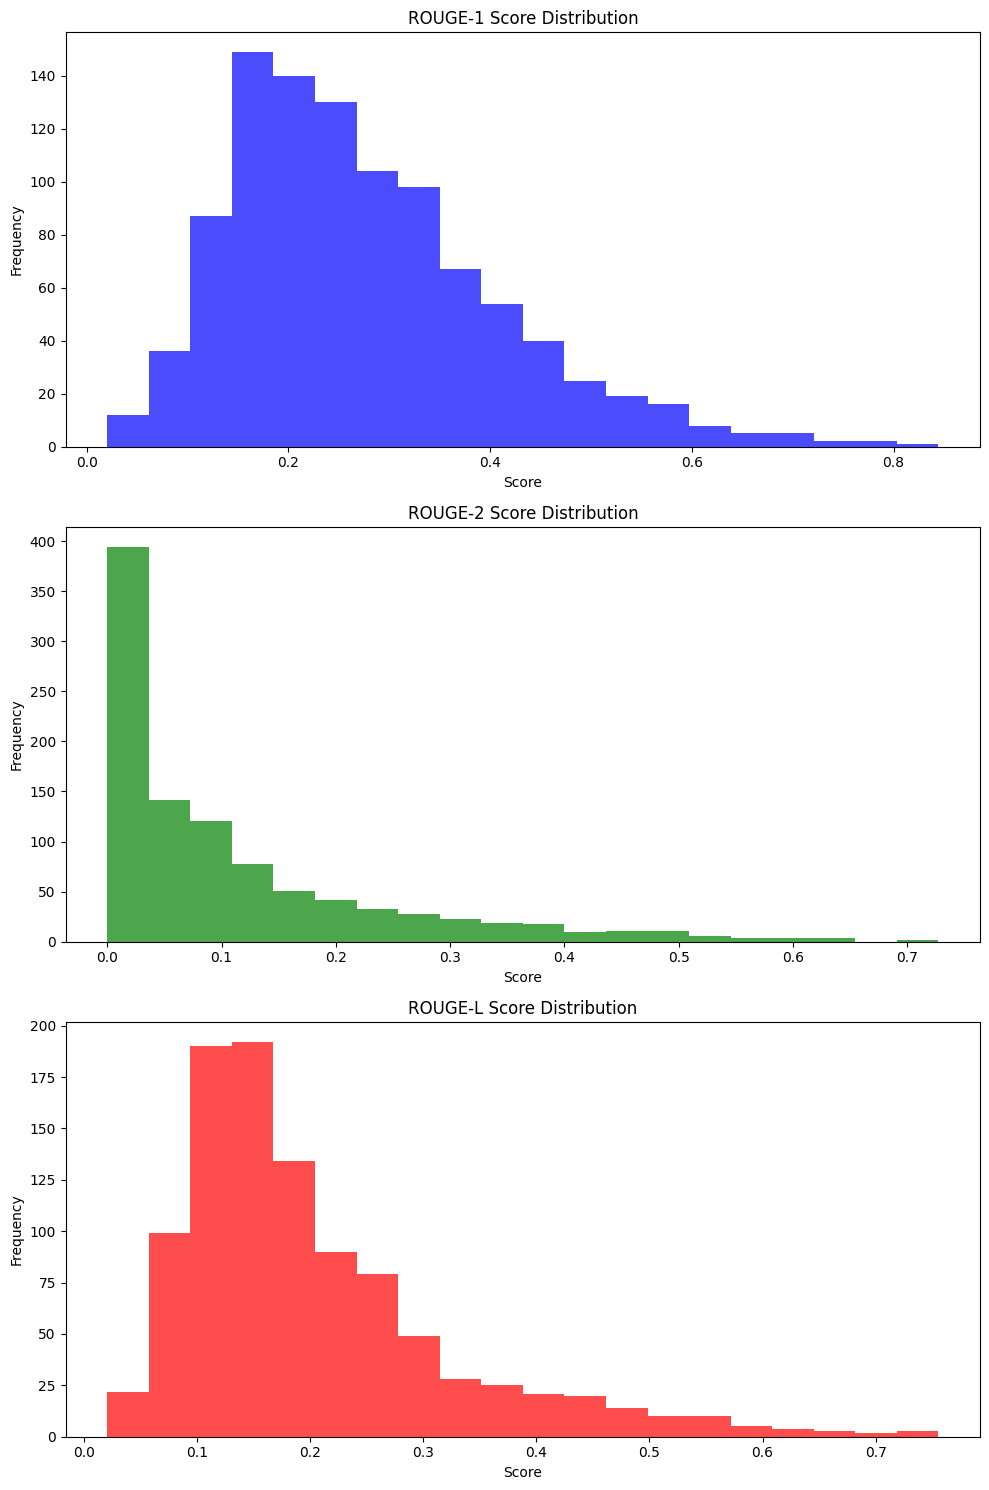

Average ROUGE-1 F-Measure: 0.275
Average ROUGE-2 F-Measure: 0.111
Average ROUGE-L F-Measure: 0.203
Overall BLEU Score: 0.042


In [37]:
import numpy as np

# Aggregating ROUGE scores
rouge1_f = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_f = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_f = [score['rougeL'].fmeasure for score in rouge_scores]

# Calculate average scores
average_rouge1 = np.mean(rouge1_f)
average_rouge2 = np.mean(rouge2_f)
average_rougeL = np.mean(rougeL_f)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].hist(rouge1_f, bins=20, color='blue', alpha=0.7)
ax[0].set_title('ROUGE-1 Score Distribution')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Frequency')

ax[1].hist(rouge2_f, bins=20, color='green', alpha=0.7)
ax[1].set_title('ROUGE-2 Score Distribution')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Frequency')

ax[2].hist(rougeL_f, bins=20, color='red', alpha=0.7)
ax[2].set_title('ROUGE-L Score Distribution')
ax[2].set_xlabel('Score')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print average scores and BLEU score
print(f"Average ROUGE-1 F-Measure: {average_rouge1:.3f}")
print(f"Average ROUGE-2 F-Measure: {average_rouge2:.3f}")
print(f"Average ROUGE-L F-Measure: {average_rougeL:.3f}")
print(f"Overall BLEU Score: {bleu_score:.3f}")
